In [62]:
import qiskit.quantum_info as qi
import constant
from qoop.core.random_circuit import generate_with_pool
from qoop.core.gradient import grad_loss
import splitter, utilities
%load_ext autoreload
%autoreload 2
num_qubits = 10
qc = generate_with_pool(num_qubits, 5)
qc = qc.assign_parameters([1] * qc.num_parameters)
qc_qasm = (qc.qasm())
print(qc_qasm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
crx(1.0) q[4],q[0];
rx(1.0) q[1];
crx(1.0) q[9],q[8];
ry(1.0) q[7];
cx q[6],q[2];
cx q[5],q[3];
ry(1.0) q[7];
h q[8];
crz(1.0) q[3],q[1];
ry(1.0) q[2];
rz(1.0) q[4];
cx q[5],q[9];
crz(1.0) q[0],q[6];
rz(1.0) q[7];
rx(1.0) q[5];
rx(1.0) q[4];
ry(1.0) q[2];
rx(1.0) q[0];
crz(1.0) q[3],q[1];
crx(1.0) q[9],q[6];
h q[8];
h q[1];
ry(1.0) q[6];
ry(1.0) q[3];
rz(1.0) q[2];
cry(1.0) q[0],q[9];
h q[7];
cx q[5],q[8];
rx(1.0) q[4];
ry(1.0) q[9];
h q[7];
h q[5];
rx(1.0) q[0];
h q[2];
ry(1.0) q[8];
rx(1.0) q[6];
crz(1.0) q[1],q[4];
rz(1.0) q[3];



In [63]:
import qiskit
import numpy as np, re

def qasm_to_qasmgates(qc_qasm):
    gates = qc_qasm.split('\n')[3:-1]
    qasm_gates = []
    for gate in gates:
        gate = gate[:-1].split(' ')
        # print(gate)
        indices = re.findall(r'\d+', gate[1])
        indices = [int(index) for index in indices]
        matches = re.match(r'([a-z]+)(\(\d+\.\d+\))?', gate[0])
        # Extract the function name and value from the matches
        name = matches.group(1).upper()
        if matches.group(2) is None:
            param = 0
        else:
            param = float(matches.group(2)[1:-1])
        qasm_gates.append((name, param, indices))
    return qasm_gates

def qasmgates_to_qcs(gates: list) -> list[qiskit.QuantumCircuit]: 
    qcs = []
    sub_qc = []
    counter = 0
    active_2qubit = 0 # 0 mean dactive, 1 mean active, 2 mean break instruction
    num_qubits = max(max(gates, key=lambda x: max(x[2]))[2]) + 1
    print(num_qubits)
    slots = np.zeros(num_qubits)
    for name, param, indices in gates: 
        if len(indices) == 2:
            active_2qubit += 1
        
        slots = utilities.update_slot(slots, indices)
        if any(slot > 1 for slot in slots) or active_2qubit == 2:
            qcs.append(sub_qc)
            active_2qubit = 0
            sub_qc = []
            sub_qc.append((name, param, indices))
            if len(indices) == 2:
                active_2qubit += 1
            slots = np.zeros(num_qubits)
            slots = utilities.update_slot(slots, indices)
            gates = gates[counter + 1:]
            counter = 0
        else:
            sub_qc.append((name, param, indices))
            counter += 1
            if counter >= len(gates):
                qcs.append(sub_qc)
                return qcs
    return qcs

qasm_gates = qasm_to_qasmgates(qc_qasm)
print(qasm_gates)
qcs = qasmgates_to_qcs(qasm_gates)
for qcss in qcs:
    print(qcss)

[('CRX', 1.0, [4, 0]), ('RX', 1.0, [1]), ('CRX', 1.0, [9, 8]), ('RY', 1.0, [7]), ('CX', 0, [6, 2]), ('CX', 0, [5, 3]), ('RY', 1.0, [7]), ('H', 0, [8]), ('CRZ', 1.0, [3, 1]), ('RY', 1.0, [2]), ('RZ', 1.0, [4]), ('CX', 0, [5, 9]), ('CRZ', 1.0, [0, 6]), ('RZ', 1.0, [7]), ('RX', 1.0, [5]), ('RX', 1.0, [4]), ('RY', 1.0, [2]), ('RX', 1.0, [0]), ('CRZ', 1.0, [3, 1]), ('CRX', 1.0, [9, 6]), ('H', 0, [8]), ('H', 0, [1]), ('RY', 1.0, [6]), ('RY', 1.0, [3]), ('RZ', 1.0, [2]), ('CRY', 1.0, [0, 9]), ('H', 0, [7]), ('CX', 0, [5, 8]), ('RX', 1.0, [4]), ('RY', 1.0, [9]), ('H', 0, [7]), ('H', 0, [5]), ('RX', 1.0, [0]), ('H', 0, [2]), ('RY', 1.0, [8]), ('RX', 1.0, [6]), ('CRZ', 1.0, [1, 4]), ('RZ', 1.0, [3])]
10
[('CRX', 1.0, [4, 0]), ('RX', 1.0, [1])]
[('CRX', 1.0, [9, 8]), ('RY', 1.0, [7])]
[('CX', 0, [6, 2])]
[('CX', 0, [5, 3]), ('RY', 1.0, [7]), ('H', 0, [8])]
[('CRZ', 1.0, [3, 1]), ('RY', 1.0, [2]), ('RZ', 1.0, [4])]
[('CX', 0, [5, 9])]
[('CRZ', 1.0, [0, 6]), ('RZ', 1.0, [7]), ('RX', 1.0, [5]), ('RX

In [60]:
A = [('CRX', 1.0, [4, 1]), ('CX', 0, [3, 5]), ('H', 0, [2])]

max_value = max(max(A, key=lambda x: max(x[2]))[2])
)

5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


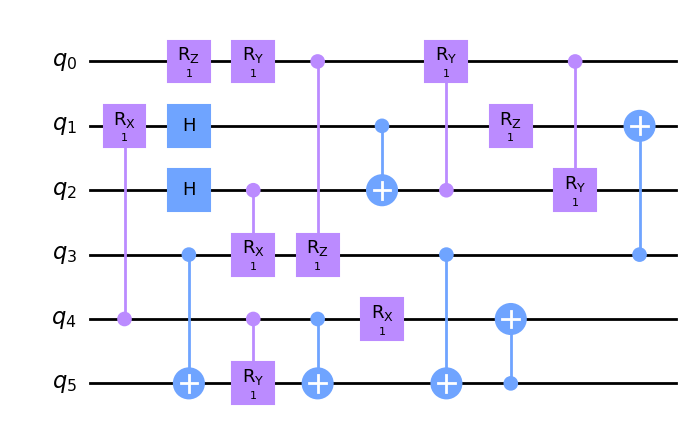

In [54]:
qc.draw('mpl')

In [33]:
import qiskit, numpy as np







